1. Reading clinicar & Patient cases

In [189]:
%reload_ext autoreload
%autoreload 2

import pprint
from loadtrials import load_trials, load_queries, get_evaluator, LONG_QUERIES


pp = pprint.PrettyPrinter(width=120, compact=True)

cases = load_queries()
long_cases = load_queries(LONG_QUERIES)
eval  = get_evaluator(cases)
ids, full_docs = load_trials(eval)

2. Creating the models

In [190]:
import index

corpus = []

for trial in full_docs:
    corpus.append(trial._brief_title)

vsm  = index.VSMindex(corpus)
lmjm = index.LMJMindex(corpus)

3. Setting filtering methods (future work)

In [191]:
import re

# TODO: define a class query where this are defined as variables of each query
age_re    = re.compile(r'(\d+)\s?(-?(year|month)(-|\s)old|yo)')
young_re  = re.compile(r'young\s(adult\s)?(man|woman|men|women)', re.IGNORECASE)
adult_re  = re.compile(r'man|woman|men|women', re.IGNORECASE)
gender_re = re.compile(r'\b(male|female|man|woman|boy|girl|men|women)\b')

def get_age(case):
    res = age_re.search(case)

    if res is None:
        # taken from: https://www.quora.com/At-what-age-does-a-female-turn-from-a-girl-to-a-lady-and-then-finally-a-woman
        # which is probably not the most trustable source ...
        case = case.lower()
        if young_re.search(case) != None:
            return 18
        if adult_re.search(case) != None:
            return 25
        return 0

    age_or_month = int(res.group(1))
    return age_or_month if res.group(3) != 'month' else age_or_month / 12

def get_gender(case):
    res = gender_re.findall(case)
    return res[0] if len(res) > 0 else 'both'


# pp.pprint(cases)

4. Calibrate paramters

In [263]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trec

plt.rcParams['figure.figsize'] = [12, 6]

class Metrics:
    # where each row is a tuple of (docid, ap, p10, mrr, ndcg5, recall)
    def __init__(self, rows, precision):#m_ap, p10, mrr, ndcg5, recall):

        self.data = pd.DataFrame(
            rows, 
            columns = ['caseid', 'ap', 'p10', 'mrr', 'ndcg@5', 'recall@100', 'relevant-documents']
        )

        self.data.set_index('caseid', inplace=True)

        # for each query we have a tuple of (precision_11point, recall_11point, total_relv_ret)
        self.precision = precision
        self.recall    = trec.RECALL_11POINT

        res = self.data.mean()#.drop(columns=['caseid']).mean()
        self.m_ap    = res['ap']
        self.m_p10   = res['p10']
        self.m_mrr   = res['mrr']
        self.m_ndcg5 = res['ndcg@5']
        self.m_recall100 = res['recall@100']

        # self.mean_precision_11point = np.sum(list(precision.values())) / len(precision)
        self.mean_precision_11point = np.mean(precision, axis=0) #np.sum(list(precision.values())) / len(precision)

        confidence = 0.99
        std_deviasion = np.std(precision, axis=0)
        mean = self.mean_precision_11point #np.mean(values, axis=0)

        diff = confidence * (std_deviasion / np.sqrt(len(precision)))

        self.upper_precision = mean + diff
        self.lower_precision = mean - diff

    

    def plot_documents_precision(self, model=''):
        self.data.plot.scatter(
            x='relevant-documents',
            y='p10',
            # colormap='viridis',
        )

        _, top = plt.ylim()
        plt.ylim(0, top)
        plt.title(f'P10/relevant-documents relation by query (for model {model})')
        # plt.savefig(f'{model}-p10-relevant-documents.pdf')
        plt.show()


    def plot_precision_recall(self, model_name):

        # values = self.precision

        # # here the axis, is the axis upon which it will iterate
        # confidence = 0.99
        # std_deviasion = np.std(values, axis=0)
        # mean = self.mean_precision_11point #np.mean(values, axis=0)

        # diff = confidence * (std_deviasion / np.sqrt(len(values)))

        plt.plot(self.recall, self.mean_precision_11point)
        plt.title(f'Precision/Recall curve for {model_name}')
        plt.xlabel("Recall", fontweight='bold')
        plt.ylabel("Precision", fontweight='bold')

        _, top = plt.ylim()
        plt.ylim(0, top)

        plt.fill_between(
            self.recall, 
            self.lower_precision,
            self.upper_precision,
            # mean - diff, 
            # mean + diff, 
            alpha=0.2
        )
        # plt.savefig(f'{model_name}-precision-recall.pdf')
        plt.show()

    def plot_top_5p10_metrics(self, model_name):
        aux = self.data.sort_values(
            by=['p10'], ascending = False
        ).drop(columns=['relevant-documents'])

        ax  = aux.head(5).plot(
            kind='bar'
        )

        for cnt in ax.containers:
            ax.bar_label(cnt, labels=[f"{round(v, 1)}" for v in cnt.datavalues])

        plt.title(f'Metrics for the first 5 queries ranked by P10 for model {model_name}')
        plt.xticks(rotation=0, horizontalalignment="center")
        plt.xlabel('Case Indentifier', fontweight='bold')

        # plt.savefig(f'{model_name}-top5-metrics.pdf')
        plt.show()



def compare_pecision_recall_models(metrics):

    for model_name, m in metrics.items():
        plt.plot(m.recall, m.mean_precision_11point, label=model_name)


        plt.fill_between(
            m.recall, 
            m.lower_precision,
            m.upper_precision,
            alpha=0.2
        )
        # plt.savefig(f'{model_name}-precision-recall.pdf')

    _, top = plt.ylim()
    plt.ylim(0, top)
    plt.xlim(0, 1)
    plt.title(f'Precision/Recall curve for all the Models')
    plt.xlabel("Recall", fontweight='bold')
    plt.ylabel("Precision", fontweight='bold')

    plt.legend(title="Models")

    # plt.savefig(f'precision-recall.pdf')
    plt.show()

def calc_metrics(index, queries) -> Metrics:

    # simple metrics rows
    rows      = []
    precision = []#{}

    for caseid, query in queries.items():
        # query = cases[caseid]
        doc_scores = index.search(query)

        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        results_ord = results.sort_values(by=['score'], ascending = False)

        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        # precision[caseid] = precision_11point #, total_relv_ret)
        precision.append( precision_11point ) #, total_relv_ret)
        

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        # add the precision at 11 points
        rows.append(
            (caseid, ap, p10, mrr, ndcg5, recall, total_relv_ret)
        )

    return Metrics(rows, precision)

# def tes
def get_metrics(index, queries) -> pd.DataFrame:
    # if path.exists('metrics.bin'):
    #     return pickle.load(open('metrics.bin', 'rb'))

    params = {}
    # avg_precision_11point = np.zeros(11)

    metrics_rows = []
    for lbd in np.arange(0, 1, 0.05):
        params['lambda'] = lbd
        index.set_params(params)
        m = calc_metrics(index, queries)
        metrics_rows.append((
            lbd, m.m_ap, m.m_p10, m.m_mrr, 
            m.m_ndcg5, m.m_recall100
        ))

    rows = pd.DataFrame(metrics_rows, columns = ['lambda', 'MAP', 'P10', 'MRR', 'NDCG@5', 'Recall@100'])
    # pickle.dump(rows, open('metrics.bin', 'wb'))
    return rows


def plot_lambdas_metrics(result : pd.DataFrame, title : str, choosen_lambda : float):

    for metric in result.columns:
        plt.plot(
            result.index, 
            result[metric], 
            label=metric,
        )

    _, top = plt.ylim()
    plt.ylim(0, top)
    plt.xlim(0, 1)
    plt.axvline(x = choosen_lambda, color = 'red', linestyle = '--', alpha = 0.5)

    plt.title(title)
    plt.legend(title='Metrics')
    plt.xlabel('Lambda values', fontweight='bold')
    plt.xticks(result.index)
    plt.show()
    # plt.figure(figsize=(100, 20))

    # plt.savefig(f'{title}.pdf')
    # plt.clf()

# Things we can do:
# - We can change the tokenizer
# - And we can change the lambdas

# MRR  => 1 over the first relevant
# NDCG => if documents respect the relevance 
# order (where K is the number of documents we will consider)

# rows.set_index('lambda', inplace=True)
# we've choosen 0.2 as the best lambda
# beause it has the maximum value for P10
# and good values for MAP and NDCG@5, while
# the rest is equals to all the rows

# TODO: test best lambda between 0.15 and 0.25

4.1 Calibrating the lambda using (short queries)

In [226]:
short_rows = get_metrics(lmjm, cases)
short_rows.set_index('lambda', inplace=True)
short_rows

,MAP,P10,MRR,NDCG@5,Recall@100
lambda,,,,,
0.00,0.007448,0.001695,0.028387,0.005748,0.036427
0.05,0.042186,0.057627,0.183455,0.049144,0.201303
0.10,0.042949,0.061017,0.183510,0.054550,0.196103
0.15,0.043679,0.062712,0.184233,0.060218,0.188799
0.20,0.043278,0.062712,0.179719,0.061554,0.190660
0.25,0.043427,0.061017,0.176952,0.061790,0.188845
0.30,0.042803,0.061017,0.175719,0.060679,0.187785
0.35,0.042004,0.059322,0.170624,0.054290,0.181705
0.40,0.041355,0.059322,0.170897,0.055774,0.175702


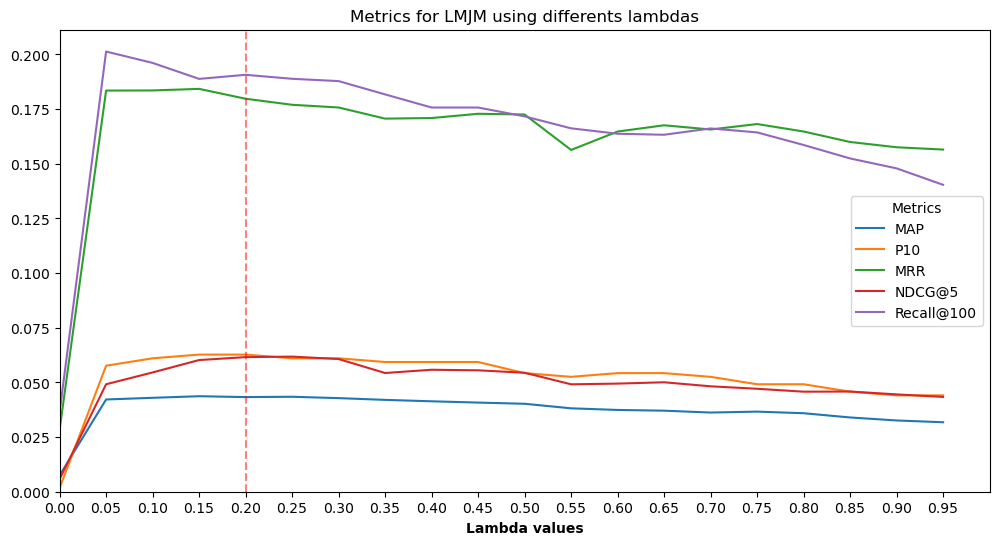

In [264]:
plot_lambdas_metrics(
    short_rows, 
    'Metrics for LMJM using differents lambdas', 
    0.2
)

4.2 Calibrating the lambdas using (long queries)

In [261]:
long_rows = get_metrics(lmjm, long_cases)
long_rows.set_index('lambda', inplace=True)
long_rows

LMJM lambda  0.0
LMJM lambda  0.05
LMJM lambda  0.1
LMJM lambda  0.15000000000000002
LMJM lambda  0.2
LMJM lambda  0.25
LMJM lambda  0.30000000000000004
LMJM lambda  0.35000000000000003
LMJM lambda  0.4
LMJM lambda  0.45
LMJM lambda  0.5
LMJM lambda  0.55
LMJM lambda  0.6000000000000001
LMJM lambda  0.65
LMJM lambda  0.7000000000000001
LMJM lambda  0.75
LMJM lambda  0.8
LMJM lambda  0.8500000000000001
LMJM lambda  0.9
LMJM lambda  0.9500000000000001


,MAP,P10,MRR,NDCG@5,Recall@100
lambda,,,,,
0.00,0.007448,0.001695,0.028387,0.005748,0.036427
0.05,0.030655,0.038983,0.150398,0.038228,0.155433
0.10,0.028597,0.032203,0.133354,0.032162,0.150452
0.15,0.026682,0.023729,0.126727,0.027676,0.149977
0.20,0.025557,0.020339,0.121144,0.027424,0.147082
0.25,0.024805,0.023729,0.120234,0.027676,0.143169
0.30,0.024022,0.023729,0.115628,0.027047,0.132034
0.35,0.023253,0.025424,0.111408,0.024498,0.129431
0.40,0.022609,0.027119,0.110688,0.024372,0.128121


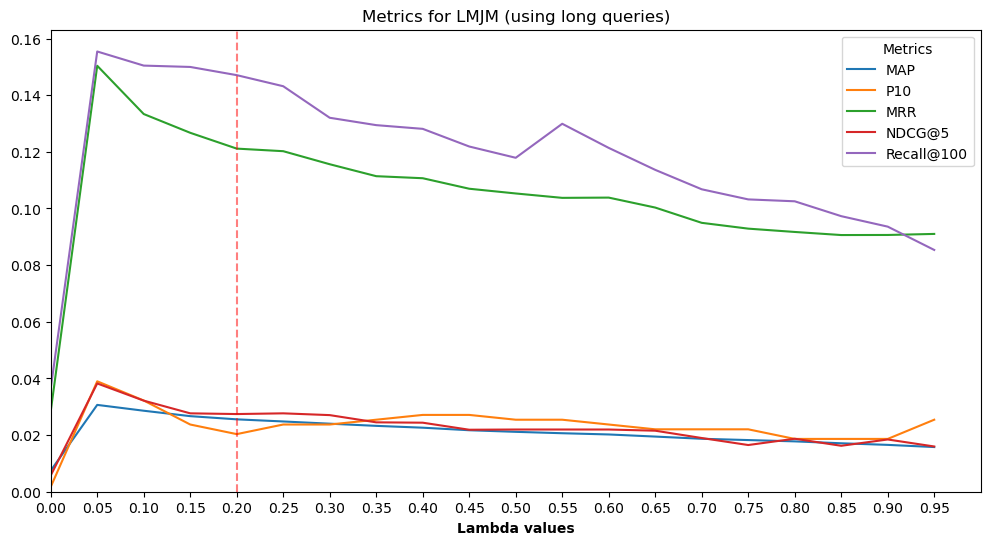

In [265]:
plot_lambdas_metrics(
    long_rows, 
    'Metrics for LMJM (using long queries)', 
    0.2
)

5. Evaluation

In [241]:
import pprint as pp
# our models
models = {
    'TF-IDF Vector Space Model': vsm, 
    'LMJM Model': lmjm
}

# seeting up parameters
lmjm.set_params({'lambda': 0.2}) 

# sub = {}
# for cid, query in list(cases.items())[:5]:
#     sub[cid] = query

# calculating metrics
models_metrics = {}
for model_name, model in models.items():
    models_metrics[model_name] = calc_metrics(model, cases)

# Charts I can do:
#    x query/relevant documents
#    X table
#    - a sort of histogram for a certain number of queries
#    - precision/recall curve


LMJM lambda  0.2


In [242]:
# [(model_name, map, mrr, p10, ndcg5, recall)]
rows = []
for model_name, m in models_metrics.items():
    rows.append((model_name, m.m_ap, m.m_mrr, m.m_p10, m.m_ndcg5, m.m_recall100))

metrics_summary = pd.DataFrame(
    rows,
    columns = ['model', 'MAP', 'MRR', 'P10', 'NDCG@5', 'Recall@100'],
)

metrics_summary.set_index('model', inplace=True)
metrics_summary

,MAP,MRR,P10,NDCG@5,Recall@100
model,,,,,
TF-IDF Vector Space Model,0.043949,0.198539,0.069492,0.063943,0.192425
LMJM Model,0.043278,0.179719,0.062712,0.061554,0.190660


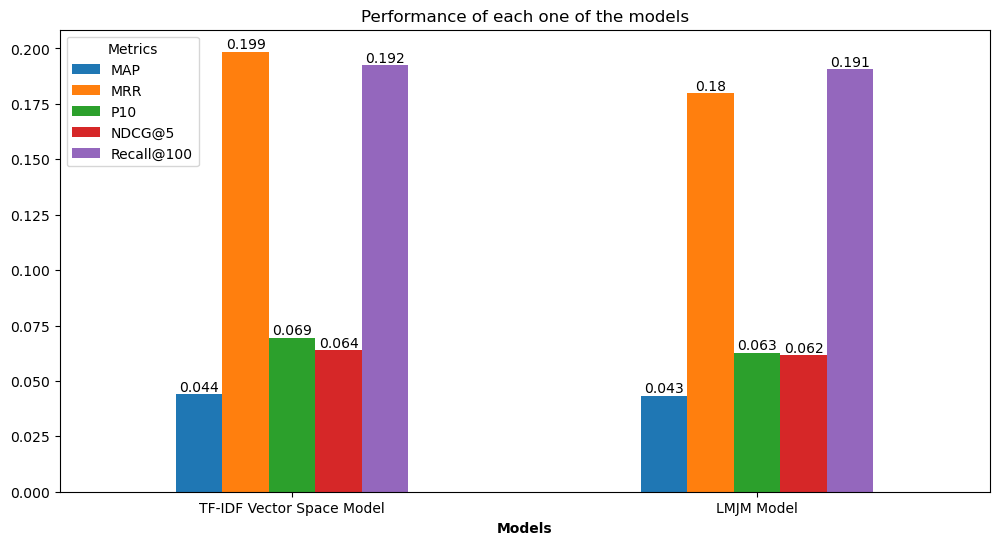

In [266]:
# charts
ax = metrics_summary.plot(
    kind='bar',
)

for cnt in ax.containers:
    ax.bar_label(cnt, labels=[f"{round(v, 3)}" for v in cnt.datavalues])

plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel('Models', fontweight='bold')
plt.title('Performance of each one of the models')
# plt.ylim(0, 0.5)
plt.legend(title='Metrics')
# plt.savefig('models-performance.pdf')
plt.show()


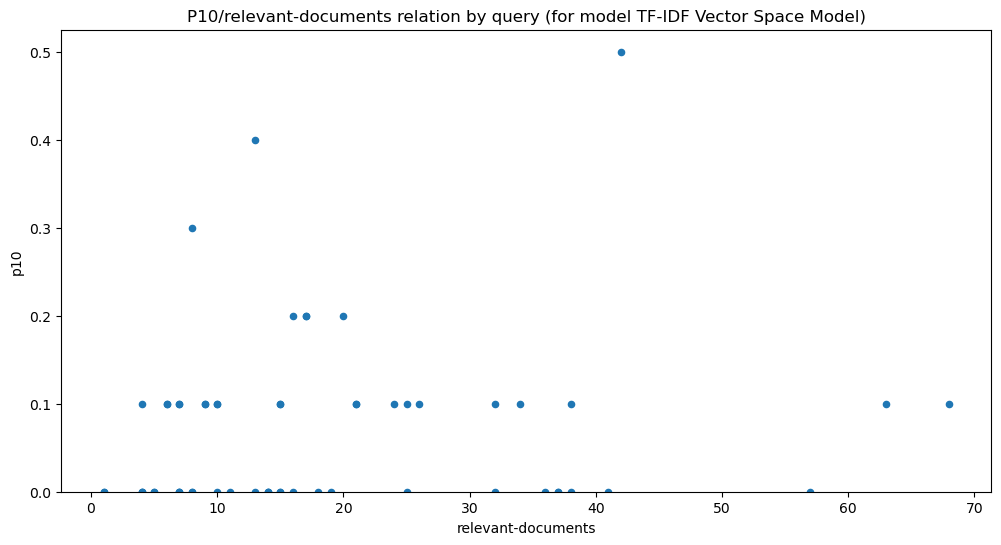

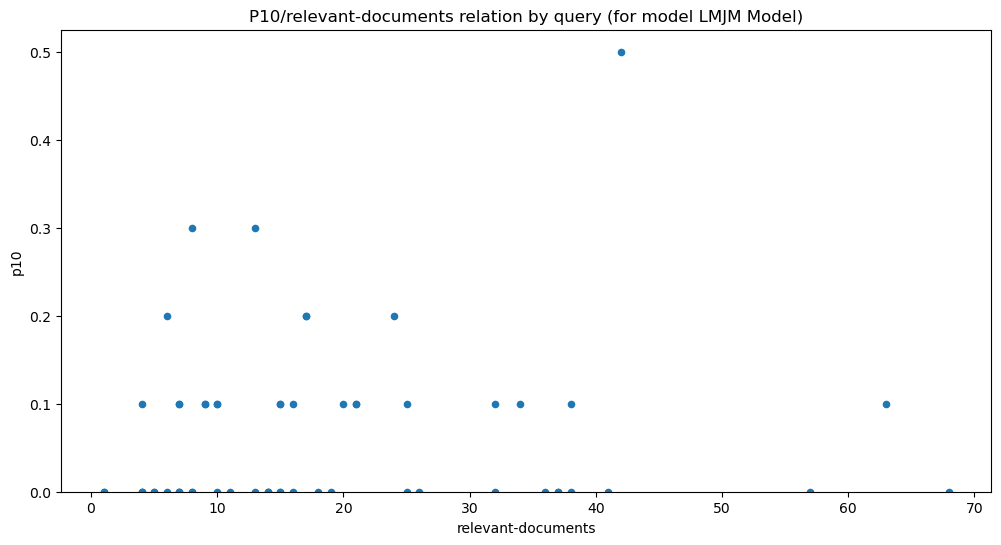

In [247]:
# p10/relevant documents charts 
for model_name, m in models_metrics.items():
    m.plot_documents_precision(model_name)



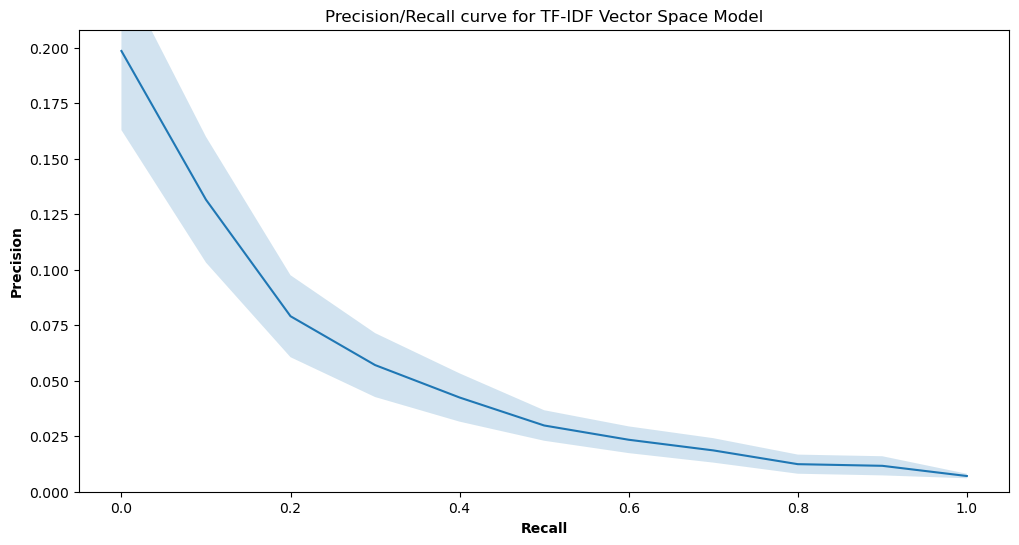

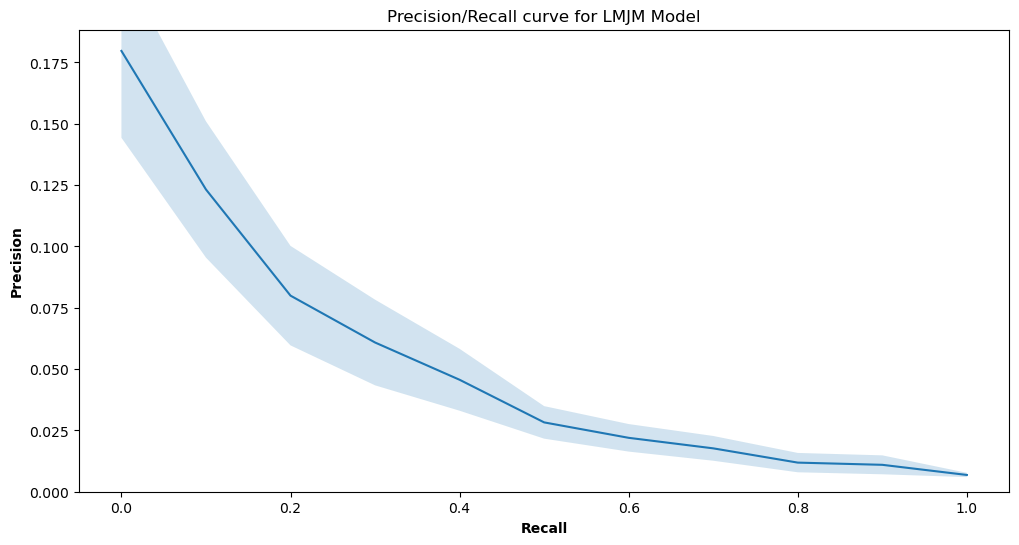

In [246]:
# precision recall curve
for name, m in models_metrics.items():
    m.plot_precision_recall(name)

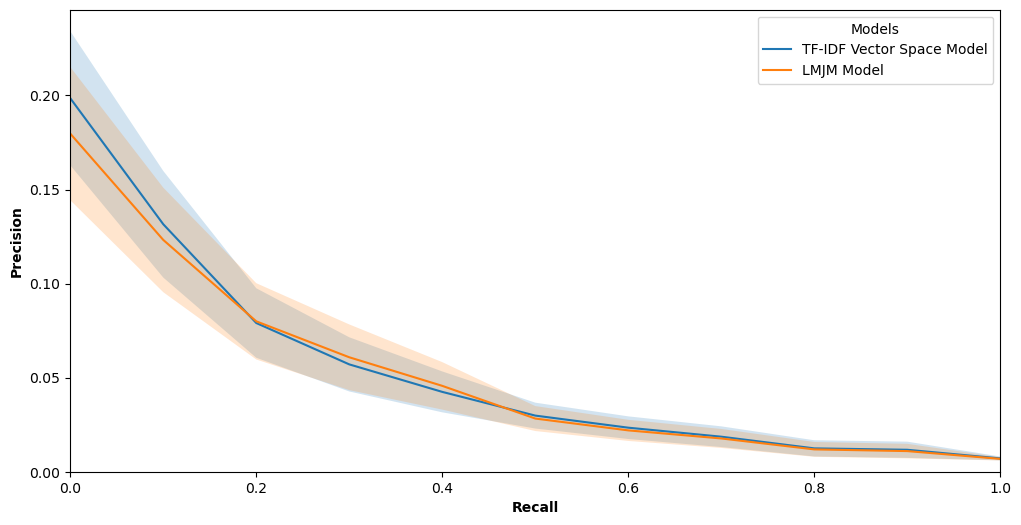

In [250]:
compare_pecision_recall_models(models_metrics) # plot the comparison of the models

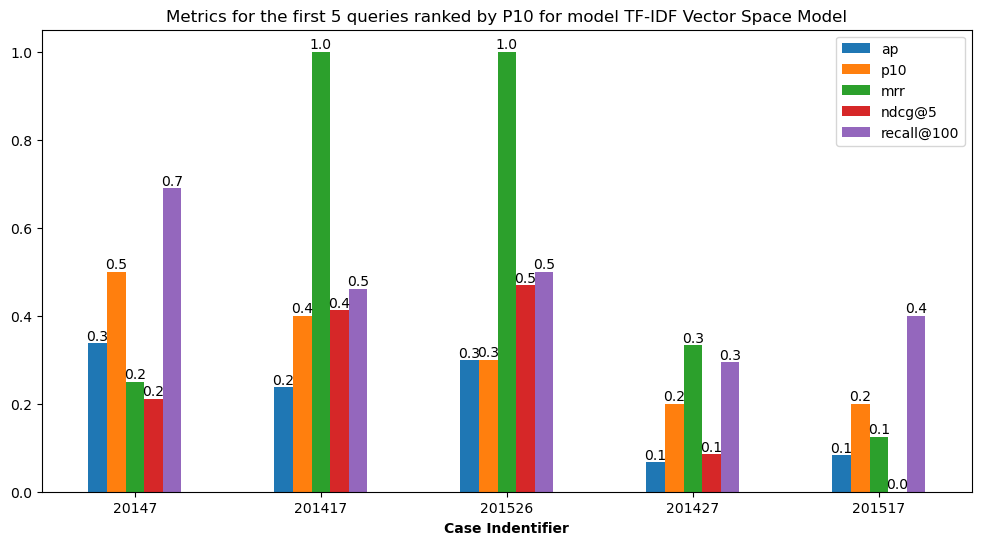

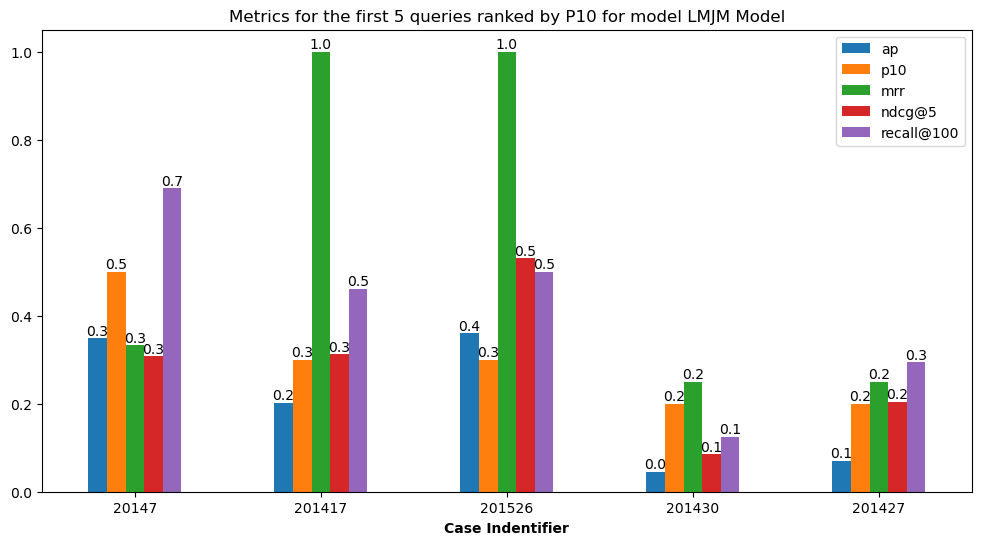

In [248]:
for name, m in models_metrics.items():
    m.plot_top_5p10_metrics(name)